In [40]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import json
import itertools
import re
import random

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from datetime import date, timedelta
from skimage.draw import ellipse
from textwrap import wrap
from IPython.display import HTML, Image

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import hamming_loss, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

plt.style.use('seaborn-white')
%matplotlib inline


# Data understaning

In [26]:
# read csv file
# 12 columns that should be in database 
columns = ['video_id', 'title', 'channel_title', 'category_id',
          'tags', 'views', 'likes', 'dislikes', 'comment_count',
          'thumbnail_link', 'trending_date']

in_vid_df =  pd.read_csv("C:/Users/akhil/Downloads/youtube-new/INvideos.csv", usecols = columns)
us_vid_df =  pd.read_csv("C:/Users/akhil/Downloads/youtube-new/USvideos.csv", usecols = columns)

# find out errors in last columns
print (in_vid_df['trending_date'].unique())
print (us_vid_df['trending_date'].unique())

# replace error items
in_vid_df.loc[in_vid_df['trending_date'] == '24.09l7yxJDFvTRM', 'trending_date'] = '24.09'
us_vid_df.loc[us_vid_df['trending_date'] == '24.09xcaeyJTx4Co', 'trending_date'] = '24.09'
in_vid_df.loc[in_vid_df['trending_date'] == '26.09t2oVUxTV4WA', 'trending_date'] = '26.09'
us_vid_df.loc[us_vid_df['trending_date'] == '26.0903jeumSTSzc', 'trending_date'] = '26.09'
us_vid_df.loc[us_vid_df['trending_date'] == '100', 'trending_date'] = '09.10'

['17.14.11' '17.15.11' '17.16.11' '17.17.11' '17.18.11' '17.19.11'
 '17.20.11' '17.21.11' '17.22.11' '17.23.11' '17.24.11' '17.25.11'
 '17.26.11' '17.27.11' '17.28.11' '17.29.11' '17.30.11' '17.01.12'
 '17.02.12' '17.03.12' '17.04.12' '17.05.12' '17.06.12' '17.07.12'
 '17.08.12' '17.09.12' '17.10.12' '17.11.12' '17.12.12' '17.13.12'
 '17.14.12' '17.15.12' '17.16.12' '17.17.12' '17.18.12' '17.19.12'
 '17.20.12' '17.21.12' '17.22.12' '17.23.12' '17.24.12' '17.25.12'
 '17.26.12' '17.27.12' '17.28.12' '17.29.12' '17.30.12' '17.31.12'
 '18.01.01' '18.02.01' '18.03.01' '18.04.01' '18.05.01' '18.06.01'
 '18.07.01' '18.08.01' '18.09.01' '18.12.01' '18.13.01' '18.14.01'
 '18.15.01' '18.16.01' '18.17.01' '18.18.01' '18.19.01' '18.20.01'
 '18.21.01' '18.22.01' '18.23.01' '18.24.01' '18.25.01' '18.26.01'
 '18.27.01' '18.28.01' '18.29.01' '18.30.01' '18.31.01' '18.01.02'
 '18.02.02' '18.03.02' '18.04.02' '18.05.02' '18.06.02' '18.07.02'
 '18.08.02' '18.09.02' '18.10.02' '18.11.02' '18.12.02' '18.13

# Correlation matirx of sentiments

In [29]:
in_vid_df.rename(columns={'comment_count':'comments'}, inplace=True)
us_vid_df.rename(columns={'comment_count':'comments'}, inplace=True)

A strong positive correlation between views and all the sentiment data (comments, likes, dislikes)is expected. As views is directly proportional to the expression of opinion.

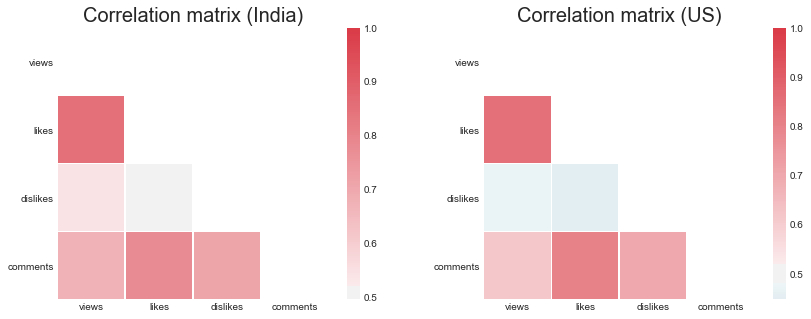

In [48]:
corr_in = in_vid_df.loc[:,['views', 'likes', 'dislikes', 'comments']].corr()
corr_us = us_vid_df.loc[:,['views', 'likes', 'dislikes', 'comments']].corr()

mask = np.zeros_like(corr_in, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1])
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax1 = plt.subplot(gs[0,0])
ax1 = sns.heatmap(corr_in, cmap=cmap, vmax=1, center=0.5,
            square=True, linewidths=.5, mask=mask)
ax1.set_title('Correlation matrix (India)', fontsize=20)
plt.yticks(rotation=0)

ax2 = plt.subplot(gs[0,1])
ax1 = sns.heatmap(corr_us, cmap=cmap, vmax=1, center=0.5,
                  square=True, linewidths=.5, mask=mask)
ax2.set_title('Correlation matrix (US)', fontsize=20)
plt.yticks(rotation=0)

plt.show()

For IN segment of YouTube everything is as expected views directly proportional to the activities. The US segment is different as dislikes seems to have their own path despite what happens with views, comments and likes. 

Visualization of these features should help a lot. Next part of the code provides functions for plotting views, comments, likes and dislikes for whole period of database. The plot is cumulative. Decreases in trend-line occur when a video with big stats is excluded from the pool of 200.

In [33]:
def vldc_plot(df_init, country):
    df = df_init[['trending_date','views', 'likes',
             'dislikes','comments']].groupby('trending_date', as_index = False).sum()
    df[['views','likes', 'dislikes','comments']] = df[['views', 'likes',
                                                       'dislikes', 'comments']].apply(lambda x: x/1000000)
    fig = plt.figure(figsize=(12, 5))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1,1])

    ax1 = plt.subplot(gs[0,0])
    ax1.plot(df['trending_date'], df['views'])
    ax1.set_xticklabels("")
    ax1.set_title('Views, mln', fontsize=20)

    ax2 = plt.subplot(gs[0,1])
    ax2.plot(df['trending_date'], df['comments'])
    ax2.set_xticklabels("")
    ax2.set_title('Comments, mln', fontsize=20)

    ax3 = plt.subplot(gs[1,0])
    ax3.plot(df['trending_date'], df['likes'])
    ax3.set_xticks(df['trending_date'].values)
    ax3.set_xticklabels(df['trending_date'], rotation=45)
    ax3.set_title('Likes, mln', fontsize=20)

    ax4 = plt.subplot(gs[1,1])
    ax4.plot(df['trending_date'], df['dislikes'])
    ax4.set_xticks(df['trending_date'].values)
    ax4.set_xticklabels(df['trending_date'], rotation=45)
    ax4.set_title('Dislikes, mln', fontsize=20)

    plt.suptitle('{} segment'.format(country), fontsize=22)

    plt.show()

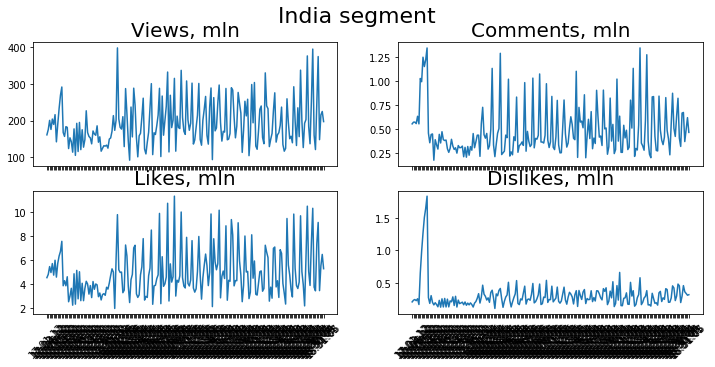

In [34]:
vldc_plot(in_vid_df, 'India')

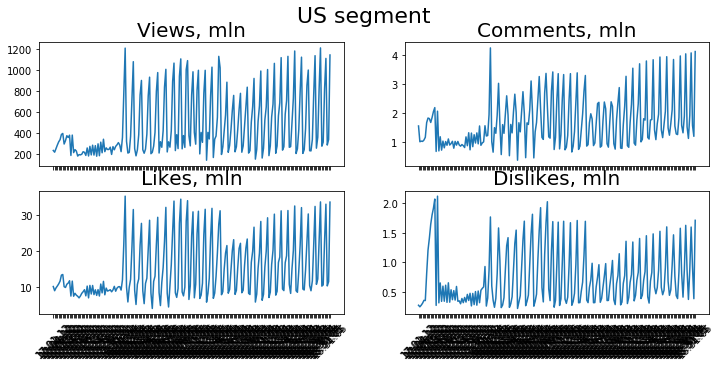

In [35]:
vldc_plot(us_vid_df, 'US')

Week correlation between dislikes and everything else in US segment is mostly guided by 16 May where high views and many likes had relatively small amount of comments and dislikes.  The database is updated regularly and is going to embrace longer period. After some time the correlation will relay less on daily data.

In [47]:
us_vid_df_corr_check = in_vid_df.loc[in_vid_df['trending_date']!=date(2018,5,16),]
corr_us = us_vid_df_corr_check.loc[:,['views', 'likes', 'dislikes', 'comments']].corr()
corr_us

,views,likes,dislikes,comments
views,1.000000,0.850096,0.543294,0.674195
likes,0.850096,1.000000,0.494560,0.780514
dislikes,0.543294,0.494560,1.000000,0.708125
comments,0.674195,0.780514,0.708125,1.000000
